<a href="https://colab.research.google.com/github/AFAgarap/autoencoders/blob/pretraining/models/x_pretrained_vgg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pretraining Autoencoder for Downstream Task
=====

## Overview 

In this notebook, we use the pretrained encoder of a mini VGG-based autoencoder as a feature extractor for a neural network.

## Setup 

We setup our dependencies.

In [0]:
!pip install --quiet tensorflow-gpu==2.0.0
!git clone https://github.com/afagarap/autoencoders
!cd autoencoders
!git checkout -b pretraining
!git pull origin pretraining

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'Abien Fred Agarap'
__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from autoencoders.models.tf.vgg_ae import CVAE

Set the memory growth of GPU.

In [0]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

Set the random number generator seed value.

In [0]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and epochs.

In [0]:
batch_size = 512
epochs = 100

## Dataset

We load the MNIST classification dataset.

In [0]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We preprocess the MNIST dataset.

In [0]:
train_features = train_features.reshape(-1, 28, 28, 1)

train_features = train_features.astype('float32')
train_features = train_features / 255.

test_features = test_features.reshape(-1, 28, 28, 1)

test_features = test_features.astype('float32')
test_features = test_features / 255.

train_labels = tf.one_hot(train_labels, len(np.unique(train_labels)))
test_labels = tf.one_hot(test_labels, len(np.unique(test_labels)))

Create the `tf.data.Dataset` object for training and evaluation.

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(batch_size * 4)
train_dataset = train_dataset.shuffle(train_features.shape[0])

test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = train_dataset.batch(batch_size)
test_dataset = train_dataset.prefetch(batch_size * 4)
test_dataset = train_dataset.shuffle(test_features.shape[0])

Instantiate the mini VGG-based autoencoder model.

In [0]:
model = CVAE(input_shape=(28, 28, 1), latent_dim=32)

Compile the model.

In [0]:
model.compile(loss=tf.losses.mean_squared_error, optimizer=tf.optimizers.Adam(learning_rate=1e-3))

Load the trained autoencoder model.

In [10]:
model.load_weights('autoencoders/assets/export/mini_vgg_ae_mnist')

Visualize the test data and the model reconstructions.

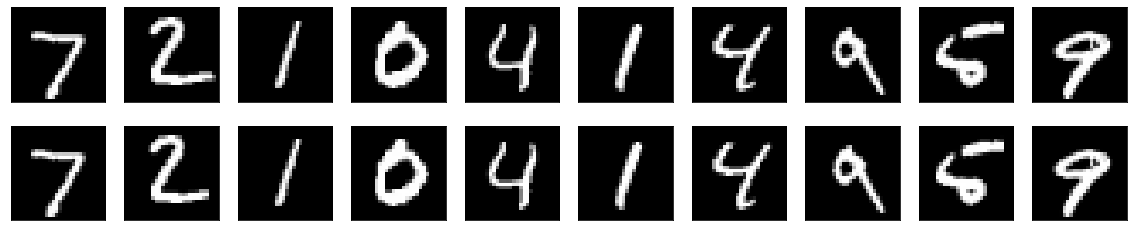

In [11]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let's check the number of parameters.

In [12]:
model.summary()

Model: "cvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  64992     
_________________________________________________________________
decoder (Decoder)            multiple                  92609     
Total params: 157,601
Trainable params: 157,601
Non-trainable params: 0
_________________________________________________________________


Freeze the encoder layer of the autoencoder.

In [0]:
model.encoder.trainable = False

Build a neural network with `model.encoder` as feature extractor.

In [0]:
class NN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NN, self).__init__()
        self.encoder = model.encoder
        self.flatten = tf.keras.layers.Flatten()
        self.dense_layer = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        self.dropout = tf.keras.layers.Dropout(rate=2e-1)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
        
    def call(self, features):
        code = self.encoder(features)
        code = self.flatten(code)
        activation = self.dense_layer(code)
        activation = self.dropout(activation)
        outputs = self.output_layer(activation)
        return outputs

Instantiate the neural network.

In [0]:
clf = NN()

Compile the neural network for training and inference.

In [0]:
clf.compile(loss=tf.losses.categorical_crossentropy,
            optimizer=tf.optimizers.SGD(
                learning_rate=1e-2, momentum=9e-1, decay=1e-6
                ),
            metrics=['accuracy'])

Train the model.

In [17]:
clf.fit(train_dataset, epochs=10, verbose=2)

Epoch 1/10
118/118 - 7s - loss: 0.5182 - accuracy: 0.8357
Epoch 2/10
118/118 - 6s - loss: 0.2612 - accuracy: 0.9227
Epoch 3/10
118/118 - 5s - loss: 0.2080 - accuracy: 0.9387
Epoch 4/10
118/118 - 5s - loss: 0.1798 - accuracy: 0.9465
Epoch 5/10
118/118 - 5s - loss: 0.1537 - accuracy: 0.9556
Epoch 6/10
118/118 - 5s - loss: 0.1382 - accuracy: 0.9594
Epoch 7/10
118/118 - 5s - loss: 0.1252 - accuracy: 0.9633
Epoch 8/10
118/118 - 5s - loss: 0.1142 - accuracy: 0.9674
Epoch 9/10
118/118 - 5s - loss: 0.1069 - accuracy: 0.9689
Epoch 10/10
118/118 - 5s - loss: 0.1002 - accuracy: 0.9706


Evaluate the performance.

In [18]:
clf.evaluate(test_dataset, verbose=2)

118/118 - 5s - loss: 0.0896 - accuracy: 0.9734


[0.08964226360164457, 0.9734]

Perturb the test data with noise from a Normal distribution having a standard deviation of `5e-2`.

In [0]:
test_features += tf.random.normal(stddev=5e-2, shape=test_features.shape)

Evaluate the model on the perturbed test data.

In [20]:
clf.evaluate(test_features, test_labels, batch_size=512, verbose=2)

10000/1 - 1s - loss: 0.2004 - accuracy: 0.9657


[0.11838725547790527, 0.9657]

Visualize the perturbed data and the reconstructions.

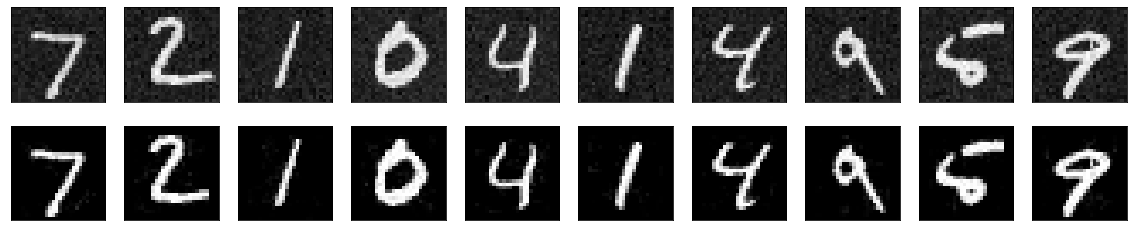

In [21]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].numpy().reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reload the test features, and increase the standard deviation of the Normal distribution from which we shall get the noise from for perturbing the test data.

In [0]:
_, (test_features, _) = tf.keras.datasets.mnist.load_data()

test_features = test_features.astype('float32') / 255.
test_features = test_features.reshape(-1, 28, 28, 1)
test_features += tf.random.normal(stddev=5e-1, shape=test_features.shape)

Visualize the test features and the reconstructions.

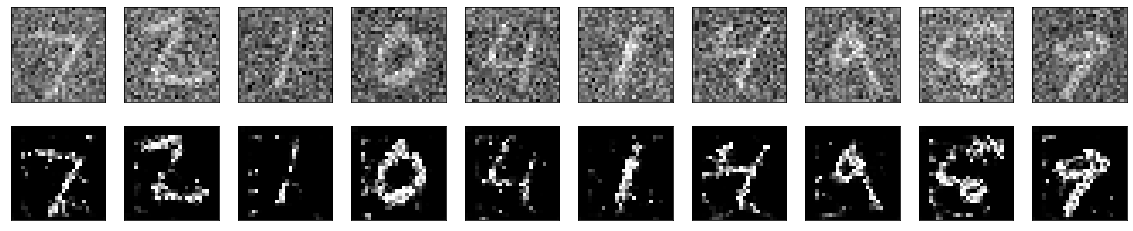

In [26]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(test_features[index].numpy().reshape(-1, 28, 28, 1)).numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Evaluate on the new perturbed test data.

In [27]:
clf.evaluate(test_features, test_labels, batch_size=batch_size, verbose=2)

10000/1 - 1s - loss: 0.5964 - accuracy: 0.8472


[0.45457758646011354, 0.8472]